In [2]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm, tqdm_notebook

# Preprocessing

### Import Dataset

In [13]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

,gene_id,description,gene_type,locus,RNA1_FPKM,RNA102_FPKM,RNA104_FPKM,RNA108_FPKM,RNA109_FPKM,RNA110_FPKM,...,R_JS032_count,R_JS033_count,R_JS034_count,R_JS035_count,R_JS036_count,R_JS037_count,R_JS038_count,R_JS039_count,R_JS040_count,R_JS041_count
gene_name,,,,,,,,,,,,,,,,,,,,,
AC073488.4,ENSG00000282222,"chromodomain protein, Y chromosome-like (CDYL)...",processed_pseudogene,X:9410789-9411545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
AC119427.1,ENSG00000282221,"novel transcript, antisense to LAD1",lncRNA,1:201399633-201401190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
MIR543,ENSG00000212040,microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664],miRNA,14:101031987-101032064,0.000000,0.000000,0.000000,0.000000,0.000000,0.962816,...,0,0,0,0,0,0,0,0,0,0
MADD,ENSG00000110514,MAP kinase activating death domain [Source:HGN...,protein_coding,11:47269161-47330031,6.345943,8.482109,10.209322,7.143557,5.671481,7.776351,...,1187,1254,1767,1184,2418,1294,1254,1461,1323,1795
AL356737.2,ENSG00000287159,"novel transcript, antisense to GPC5",lncRNA,13:92610646-92677725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


### Check Gene Types

In [14]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [15]:
df = df[df['gene_type'] == 'IG_V_pseudogene']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset17/data0.csv')

### Combine with Diagnosis

In [16]:
df = pd.read_csv('../Datasets/Dataset17/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset17/data1.csv')

df.head()

,IGKV1OR22-5,IGHVII-28-1,IGKV1-32,IGLVIV-66-1,IGKV2OR22-3,IGHVIV-44-1,IGHV3-54,IGKV2D-38,IGLVI-20,IGHV3OR16-6,...,IGHV3-63,IGHV4-55,IGHV3-47,IGKV1OR9-1,IGHV3-6,IGHVIII-76-1,IGLV3-24,IGLV1-62,IGHV1OR16-3,Diagnosis
RNA1_FPKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.277770,0.000000,0.360282,0.0,1
RNA102_FPKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.263472,0.000000,0.341737,0.0,2
RNA104_FPKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.221025,0.0,0.0,0.517786,0.000000,0.000000,0.0,1
RNA108_FPKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.408054,0.182283,0.0,1
RNA109_FPKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.615359,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.279709,0.406075,0.000000,0.0,0


### Remove Patients who hasn't Diabetic

In [17]:
df = pd.read_csv('../Datasets/Dataset17/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset17/data2.csv")
df.head()

,IGKV1OR22-5,IGHVII-28-1,IGKV1-32,IGLVIV-66-1,IGKV2OR22-3,IGHVIV-44-1,IGHV3-54,IGKV2D-38,IGLVI-20,IGHV3OR16-6,...,IGHV3-63,IGHV4-55,IGHV3-47,IGKV1OR9-1,IGHV3-6,IGHVIII-76-1,IGLV3-24,IGLV1-62,IGHV1OR16-3,Diagnosis
RNA1_FPKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.277770,0.000000,0.360282,0.0,0
RNA102_FPKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.263472,0.000000,0.341737,0.0,1
RNA104_FPKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.221025,0.0,0.0,0.517786,0.000000,0.000000,0.0,0
RNA108_FPKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.408054,0.182283,0.0,0
RNA110_FPKM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0


### Analyze the Dataset

In [18]:
df = pd.read_csv("../Datasets/Dataset17/data2.csv", index_col=0)
df.describe()

,IGKV1OR22-5,IGHVII-28-1,IGKV1-32,IGLVIV-66-1,IGKV2OR22-3,IGHVIV-44-1,IGHV3-54,IGKV2D-38,IGLVI-20,IGHV3OR16-6,...,IGHV3-63,IGHV4-55,IGHV3-47,IGKV1OR9-1,IGHV3-6,IGHVIII-76-1,IGLV3-24,IGLV1-62,IGHV1OR16-3,Diagnosis
count,143.0,143.000000,143.0,143.0,143.0,143.0,143.0,143.0,143.000000,143.000000,...,143.0,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.0,0.040937,0.0,0.0,0.0,0.0,0.0,0.0,0.046359,0.001559,...,0.0,0.018825,0.008538,0.002001,0.003917,0.097373,0.100042,0.088726,0.013411,0.468531
std,0.0,0.138282,0.0,0.0,0.0,0.0,0.0,0.0,0.369500,0.018641,...,0.0,0.076022,0.045415,0.023928,0.046837,0.184964,0.287686,0.157864,0.084644,0.500763
min,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.209440,0.000000,0.170997,0.000000,1.000000
max,0.0,0.689687,0.0,0.0,0.0,0.0,0.0,0.0,4.279009,0.222911,...,0.0,0.581785,0.296011,0.286141,0.560094,0.849262,1.642450,1.009252,0.780784,1.000000


In [19]:
df.dtypes

IGKV1OR22-5     float64
IGHVII-28-1     float64
IGKV1-32        float64
IGLVIV-66-1     float64
IGKV2OR22-3     float64
                 ...   
IGHVIII-76-1    float64
IGLV3-24        float64
IGLV1-62        float64
IGHV1OR16-3     float64
Diagnosis         int64
Length: 188, dtype: object

In [20]:
df.isnull().sum()

IGKV1OR22-5     0
IGHVII-28-1     0
IGKV1-32        0
IGLVIV-66-1     0
IGKV2OR22-3     0
               ..
IGHVIII-76-1    0
IGLV3-24        0
IGLV1-62        0
IGHV1OR16-3     0
Diagnosis       0
Length: 188, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [21]:
df = pd.read_csv("../Datasets/Dataset17/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  0   2   3   4   5   6   7  12  14  15  17  18  19  20  23  24  26  33
  35  36  40  42  44  49  50  52  59  60  62  64  65  66  67  69  71  74
  75  76  78  82  83  85  86  87  91  98 100 101 103 105 107 109 112 113
 114 116 117 118 121 122 126 128 129 132 134 143 147 148 149 150 151 153
 154 157 160 162 163 164 165 168 173 174 175 176 177 178] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  0   2   3   4   5   6   7  12  14  15  17  18  19  20  23  24  26  33
  35  36  40  42  44  49  50  52  59  60  62  64  65  66  67  69  71  74
  

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.53+/-0.09
1   Information Gain (Mutual info)            50            0.53+/-0.09
2   Information Gain (Mutual info)           100            0.53+/-0.09
3   Information Gain (Mutual info)           150            0.53+/-0.09
4          Correlation Coefficient            25            0.53+/-0.09
5          Correlation Coefficient            50            0.53+/-0.09
6          Correlation Coefficient           100            0.50+/-0.09
7          Correlation Coefficient           150            0.57+/-0.08
8                       Chi-Square            25            0.53+/-0.09
9                       Chi-Square            50            0.53+/-0.09
10                      Chi-Square           100            0.48+/-0.08
11                      Chi-Square           150            0.54+/-0.02
12              Feature Importance            25            0.55

### Check Feature Importance

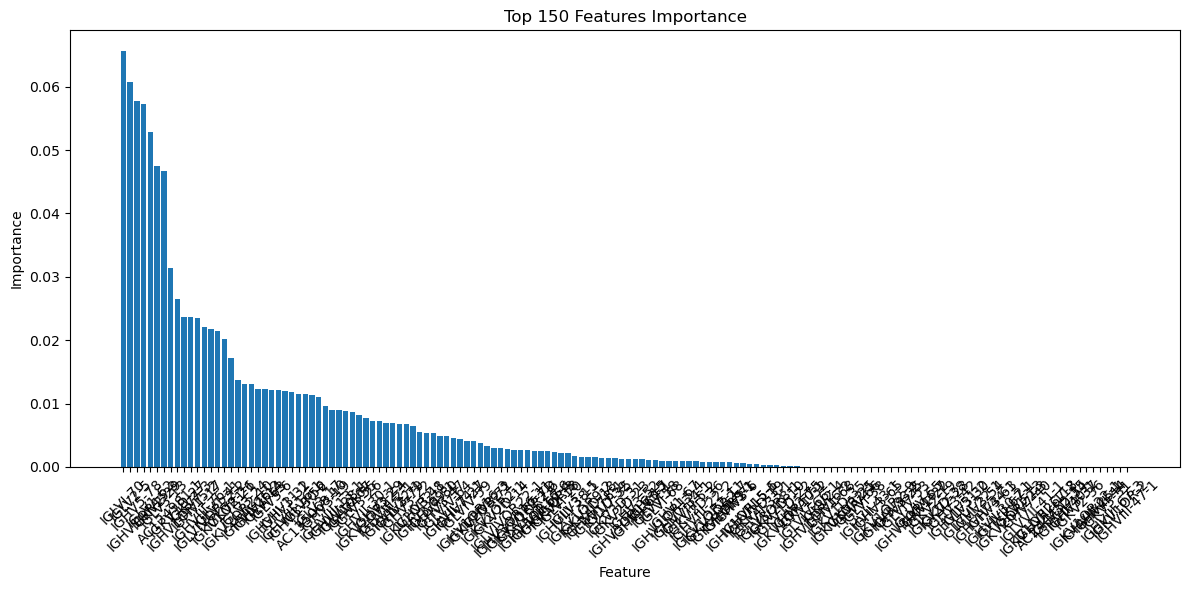

Last important feature:  101


In [22]:
df = pd.read_csv("../Datasets/Dataset17/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [150]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [23]:
df = pd.read_csv("../Datasets/Dataset17/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset17/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [24]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in tqdm(feature_counts, desc="Processing feature counts", unit=" feature counts", colour='green'):
    file_path = f"../Datasets/Dataset17/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        if model_name == "ANN":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        elif model_name == "Logistic Regression": 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        else:
            scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        # print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset17/Feature_Select/results.csv", index=False)

Processing feature counts: 100%|██████████| 143/143 [05:31<00:00,  2.32s/ feature counts]


In [25]:
df = pd.read_csv("../Datasets/Dataset17/Feature_Select/results.csv")
df.head(10)

,Model Name,Feature Count,CV Score (Mean +/- Std)
0,Naive Bayes,47,0.6276 +/- 0.0703
1,Naive Bayes,48,0.6207 +/- 0.0723
2,Naive Bayes,44,0.6138 +/- 0.0798
3,Naive Bayes,46,0.6138 +/- 0.0798
4,Naive Bayes,45,0.6069 +/- 0.0889
5,Naive Bayes,43,0.6069 +/- 0.0833
6,Naive Bayes,49,0.6069 +/- 0.0560
7,Naive Bayes,42,0.6000 +/- 0.0889
8,Naive Bayes,51,0.6000 +/- 0.0640
9,Naive Bayes,50,0.6000 +/- 0.0640


### Check Distributions

In [6]:
feature_count = 47

data = pd.read_csv(
    f'../Datasets/Dataset17/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

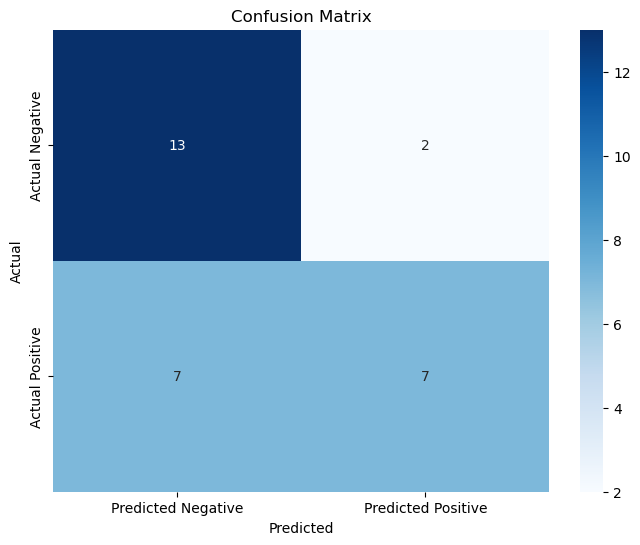

Accuracy: 0.69
Precision: 0.78
Recall (Sensitivity): 0.50
Specificity: 0.87
F1 Score: 0.61


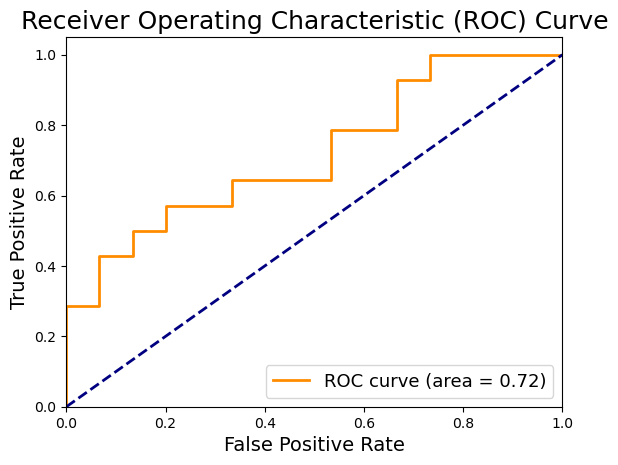

In [10]:
# feature_count = 43

df = pd.read_csv(
    f'../Datasets/Dataset17/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()